In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [2]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [3]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(41) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y", start="2018-01-01", end="2020-12-31")
    US10_stocks_prices[stock] = historical_data

In [4]:
US10_Stocks

['PM', 'NKE', 'ACN', 'ABBV', 'AMGN', 'ELV', 'CVS', 'NFLX', 'T', 'CMCSA']

利用股價生成日報酬

In [5]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [6]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [7]:
pd.DataFrame(US10_stocks_returns)

,PM,NKE,ACN,ABBV,AMGN,ELV,CVS,NFLX,T,CMCSA
0,-0.001246,-0.000158,0.004615,0.015649,0.018870,0.013938,-0.004353,0.019794,-0.023093,-0.016070
1,-0.007577,-0.000630,0.011841,-0.005703,-0.004214,0.004626,0.026366,0.002829,0.009296,0.006434
2,0.008022,0.008512,0.008249,0.017408,0.005958,0.017940,0.044190,0.021203,0.003684,0.009098
3,-0.001534,0.008909,0.007992,-0.016022,-0.000277,-0.010754,-0.008668,0.009810,0.002884,-0.013645
4,0.007202,-0.007126,0.003335,0.007538,0.015393,0.012251,-0.001029,-0.012922,-0.002607,0.003212
...,...,...,...,...,...,...,...,...,...,...
749,0.000122,-0.004844,-0.007824,0.004669,0.008824,0.016650,0.011752,-0.024368,0.012324,0.000400
750,0.003771,-0.001129,-0.000544,-0.000194,-0.000045,0.001038,-0.000588,-0.000991,-0.002087,0.006795
751,-0.000243,0.005861,0.009250,0.001840,0.003230,0.013672,0.001618,0.010020,-0.004880,0.014490
752,-0.007516,-0.006038,-0.007394,0.012083,0.014398,0.004602,-0.002644,0.022634,-0.000350,0.008609


計算統計數字

In [8]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

PM      -0.069801
NKE      1.300751
ACN      0.753489
ABBV     0.239234
AMGN     0.398965
ELV      0.441624
CVS      0.011494
NFLX     1.608992
T       -0.055433
CMCSA    0.323199
dtype: float64

In [9]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,PM,NKE,ACN,ABBV,AMGN,ELV,CVS,NFLX,T,CMCSA
PM,0.000383,0.000158,0.000169,0.000149,0.000147,0.000224,0.000167,0.000101,0.000174,0.000179
NKE,0.000158,0.000399,0.000220,0.000164,0.000145,0.000243,0.000153,0.000176,0.000160,0.000175
ACN,0.000169,0.000220,0.000340,0.000190,0.000181,0.000240,0.000180,0.000201,0.000173,0.000207
ABBV,0.000149,0.000164,0.000190,0.000422,0.000194,0.000236,0.000182,0.000151,0.000147,0.000158
AMGN,0.000147,0.000145,0.000181,0.000194,0.000327,0.000206,0.000177,0.000203,0.000142,0.000163
ELV,0.000224,0.000243,0.000240,0.000236,0.000206,0.000581,0.000268,0.000168,0.000192,0.000207
CVS,0.000167,0.000153,0.000180,0.000182,0.000177,0.000268,0.000406,0.000143,0.000179,0.000181
NFLX,0.000101,0.000176,0.000201,0.000151,0.000203,0.000168,0.000143,0.000723,0.000094,0.000168
T,0.000174,0.000160,0.000173,0.000147,0.000142,0.000192,0.000179,0.000094,0.000285,0.000193
CMCSA,0.000179,0.000175,0.000207,0.000158,0.000163,0.000207,0.000181,0.000168,0.000193,0.000345


切線法(目前是錯的)

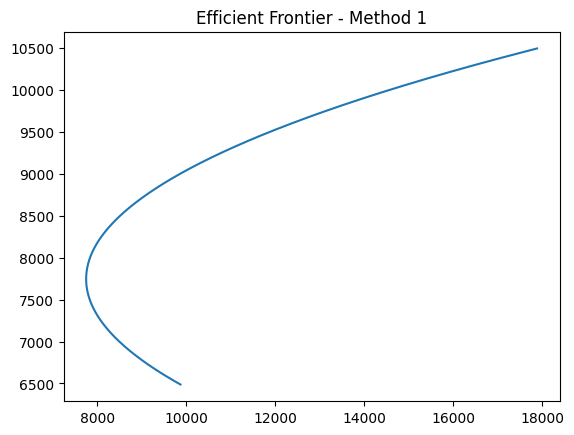

In [22]:
#代講義p.24的矩陣式

f = mean_returns.values

#建立不同的無風險利率(-1 ~ 1)
Rfs = np.linspace(-1, 1, 1000)

weights = []
for Rf in Rfs:
    Rf = np.full((f.shape[0], 1), Rf)
    f = f.reshape(10, 1)
    Rbar = f + Rf
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    V_inv_Rbar = np.dot(V_inv, Rbar)

    # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    ones_vector = np.ones((10, 1))
    V_inv_ones = np.dot(V_inv, ones_vector)

    # 計算 Rf * (V^(-1) * 1)
    Rf_V_inv_ones = Rf * V_inv_ones
    Z = V_inv_Rbar - Rf_V_inv_ones

    # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    Z_transpose = Z.T
    Z_dot_ones = np.dot(Z_transpose, ones_vector)

    # 最後計算 X
    X = V_inv_Rbar - Rf_V_inv_ones / Z_dot_ones
    weights.append(X)


vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

plt.title('Efficient Frontier - Method 1')
plt.plot(vars, fp)


火腿法

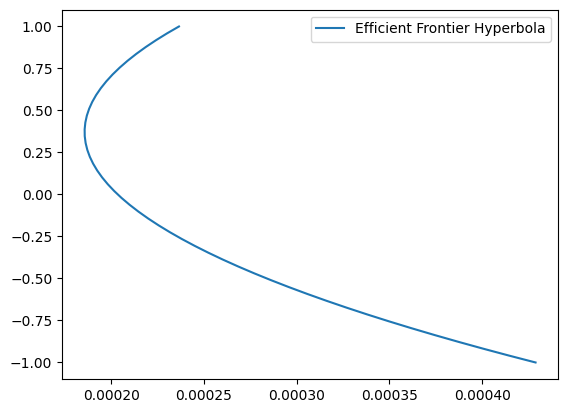

In [23]:
#代講義推導出的公式(p.28)

f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率
Rfs = np.linspace(-1, 1, 50)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - (u * B)) / D
    _gamma = ((A * u) - B) / D
    h = (_lambda * V_inv @ e) + (_gamma * V_inv @ f)
    weights.append(h)

hC = (np.linalg.inv(cov_matrix.values) @ e) / (e.T @ np.linalg.inv(cov_matrix.values) @ e)
hQ = (np.linalg.inv(cov_matrix.values) @ f) / (f.T @ np.linalg.inv(cov_matrix.values) @ e)

hC_point = (np.dot(hC.T, cov_matrix.values) @ hC, np.dot(hC.T, f))
hQ_point = (np.dot(hQ.T, cov_matrix.values) @ hQ, np.dot(hQ.T, f))

vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

fig, ax = plt.subplots()
# # 繪製hQ跟hC
# plt.title('Efficient Frontier')
# plt.scatter(*hC_point, c='red', s=10)
# plt.annotate('hC', xy=hC_point)
# plt.scatter(*hQ_point, c='green', s=10, label='QML')
# plt.annotate('hQ', xy=hQ_point)
plt.plot(vars, fp, label= 'Efficient Frontier Hyperbola')
plt.legend()

C:\Users\USER\AppData\Local\Temp\ipykernel_16532\3657396850.py:43: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = opt.minimize(objective, init_h, method='SLSQP', bounds=bound, constraints=conditions)


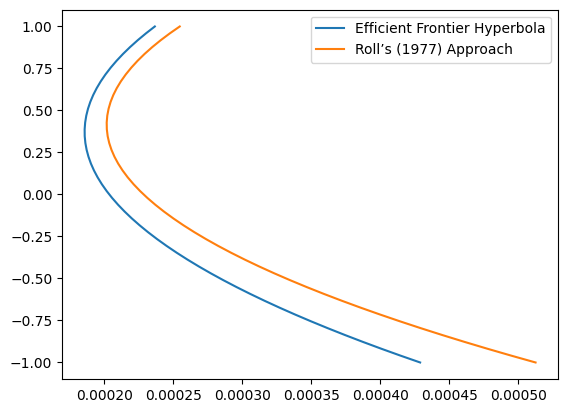

In [24]:
#火腿法的規劃求解(p.25)

f = mean_returns.values

#定義取得fp及Varp的函數
def get_fp(h):
    return np.dot(h.T, f)

def get_Varp(h):
    return np.dot(np.dot(h.T, cov_matrix.values), h)

#引入規劃求解套件
import scipy.optimize as opt

#目標式
def objective(h):
    return 0.5*get_Varp(h)


#定義限制式1，h的總和要為1
def constraint1(h):
    return np.sum(h) - 1

#定義限制式2，fp要等於我們設定的目標報酬率(即Rf)
def constraint2(h):
    return get_fp(h) - Rf

#設定h的權重要在-1~1之間
bound = tuple((-1,1) for _ in range(f.shape[0]))


#將兩個限制式打包成一個tuple
conditions = ({'type':'eq', 'fun':constraint1}, 
              {'type':'eq', 'fun':constraint2})

#隨便給一個求解的起始值(每個都先給0.1)
init_h = np.full((f.shape[0], 1), 1/f.shape[0])

#先設定Rf範圍，再各別求最佳解
Rfs = np.linspace(-1, 1, 50)
h_weights = []
for idx, Rf in enumerate(Rfs):
    result = opt.minimize(objective, init_h, method='SLSQP', bounds=bound, constraints=conditions)
    h_weights.append(result.x)

fig, ax = plt.subplots()
plt.plot(vars, fp, label='Efficient Frontier Hyperbola')
plt.plot([get_Varp(h) for h in h_weights], [get_fp(h) for h in h_weights], label='Roll’s (1977) Approach')

plt.legend()